# Comparison between Different Methods for UQ Forward Problem
 **Saleh Rezaeiravesh and Philipp Schlatter** <br/> 
 saleh.rezaeiravesh@manchester.ac.uk and pschlatt@mech.kth.se <br/> 
 Modelling & Simulation, Department of Mechanical, Aerospace and Civil Engineering (MACE), The University of Manchester, UK <br/> 
 SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Sweden
___

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import math as mt

In this notebook, we compare the stochastic mean and variance of $y=f(q)$ for 1D parameter using three different methods:
    
* Perturbation method, 
* Monte Carlo Method,
* Polynomial Chaos Expansion

Consider the following algebraic equation,
$$
y=f(q)=q+0.7 \sin(5 q) + 3 \cos(q) \,,
$$
which depends on parameter $q$. Here we assume, $q\sim \mathcal{N}(1,0.3^2)$ and use PCE to construct mean and variance of $f(q)$.

## Perturbation Method

The sensitivity index reads as, 

$$
s_q=\frac{\partial f}{\partial q} = 1+3.5 \cos(5q)-3\sin(q).
$$

## Monte Carlo Method

In [2]:
nMC=100000  
qMC=np.random.normal(loc=1,scale=0.3,size=nMC)
yMC=qMC+0.7*np.sin(5*qMC)+3*np.cos(qMC)

In [3]:
print('Monte Carlo Method:')
print('E[f(q)]=%g and V[f(q)]=%g'  %(np.mean(yMC),np.var(yMC)))

Monte Carlo Method:
E[f(q)]=2.33069 and V[f(q)]=0.231251


Text(0, 0.5, 'y')

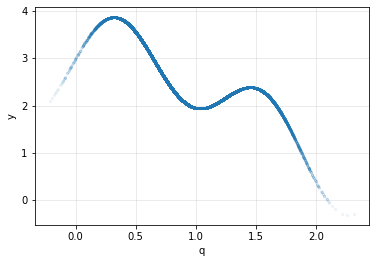

In [4]:
#plot model function 
plt.plot(qMC,yMC,'o',alpha=0.1,ms=2,mfc='none')
plt.grid(alpha=0.3)
plt.xlabel('q')
plt.ylabel('y')

Text(0.5, 0, 'y')

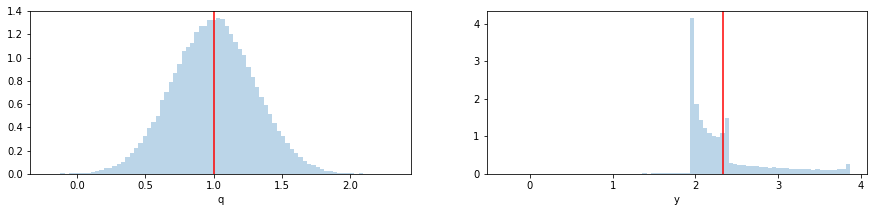

In [5]:
#Plot distribution of q and f(q)
plt.figure(figsize=(15,3))
plt.subplot(121)
_=plt.hist(qMC,density=True,bins=80,alpha=0.3)
plt.axvline(x=np.mean(qMC),color='red')
plt.xlabel('q')
plt.subplot(122)
_=plt.hist(yMC,density=True,bins=80,alpha=0.3)
plt.axvline(x=np.mean(yMC),color='red')
plt.xlabel('y')

## Polynomial Chaos Expansion

Basis functions based on the generalized PCE (only for uniform and normal distributions)

In [6]:
#gPCE basis taken from UQit
def gPCE_basis(n_,xi_,distType_):
    """
    Evaluates gPCE polynomial basis of order `n_` at `xi_` points taken from the mapped 
    space :math:`\Gamma`.
    The standard polynomials are chosen based on the gPCE rules.        
    Args:
      `n_`: int
         Order of the basis
      `xi_`: 1D numpy array of size m
         Points taken from the mapped space
      `distType_`: string
         Distribution type of the random parameter (based on the gPCE rule)
       
    Returns:
      `psi`: 1D numpy array of size m
         Values of the gPCE basis at `xi_`     
    """
    if distType_=='Unif':
       psi=np.polynomial.legendre.legval(xi_,[0]*n_+[1])
    elif distType_=='Norm':
       psi=np.polynomial.hermite_e.hermeval(xi_,[0]*n_+[1])
    return psi

Function `gqPtsWts()` returns the quadrature nodes and weights based on the gauss-quadrature rule given the number of quadrature points and standard distribution of the random variable (only uniform and Gaussian distributions are implemented here).

In [7]:
#Gauss-Quadrature rule, taken from UQit
def gqPtsWts(n_,distType_):
    """
    Gauss quadrature nodes and weights associated to distribution type `type_`
    based on the gPCE rule.
    Args:
       `n_`: int, 
           Order of the gPCE polynomial.
       `type_`: string, 
           Distribution of the random variable according to the gPCE rule
    Returns:
       `quads`: 1D numpy array of size `n_` 
        Gauss quadrature nodes
        `weights`: 1D numpy array of size `n_` 
        Gauss quadrature weights
    """
    if distType_=='Unif':
       x_=np.polynomial.legendre.leggauss(n_)
    elif distType_=='Norm':
       x_=np.polynomial.hermite_e.hermegauss(n_)
    quads=x_[0]
    weights=x_[1]    
    #Multipliers for the Gauss-quadrature integration rule, when using the weights provided by numpy.    
    if distType_=='Unif':
       fac_=0.5
    elif distType_=='Norm':
       fac_=1./mt.sqrt(2*mt.pi)
    return quads,weights,fac_

Function `gqRule()` uses `gqPtsWts()` and works for one or more uncertain parameters. It also maps $\xi\in\Gamma$ to $q\in\mathbb{Q}$ for Uniform and Gaussian distributions.

In [8]:
def gqRule(n,distType,qInfo):
    """
    Weight and xi\in\Gamma based on the GQ rule    
    Args:
        `n`: list of GQ points for each parameter
        `distType`: list of distribution type of the parameters, 'Unif', 'Norm'
        `qInfo`: List of length 2 (optional)       
            `qInfo`=[qMin,qMax] if distType=='Unif'
            `qInfo`=[mean,sdev] if distType=='Norm'
    """
    p=len(distType)   #dimenionality of the parameters
    
    xi=[]
    w=[]
    integFac=[]
    qGQ=[]    
    for i in range(p):
        xi_,w_,fac_=gqPtsWts(n[i],distType[i])    
        xi.append(xi_)
        w.append(w_)
        integFac.append(fac_)
        if distType[i]=='Unif':
           qGQ.append((0.5*(xi_+1.0)*(qInfo[i][1]-qInfo[i][0])+qInfo[i][0]))
        elif distType[i]=='Norm':
           qGQ.append(qInfo[i][0]+qInfo[i][1]*xi_)
    return xi,w,integFac,qGQ   

The following small python function shows an implementation of PCE:

In [9]:
def gPCE1D_cnstrct(nGQ,xi,w,integFac,fGQ,distType):
    """
    Construct PCE for one parameter    
    
    `fGQ`: numpy array of size n
    distType='Unif', 'Norm'
    """    
    K=nGQ
    
    fCoef=np.zeros(K)   #PCE Coefficients
    pce_inn=np.zeros(K) #PCE inner-product
    
    for k in range(nGQ): 
        psi_k=gPCE_basis(k,xi,distType)        
        
        sum1=np.sum(fGQ*psi_k[0]*w[0])
        sum2= np.sum(psi_k[0]**2.*w[0])
        
        fCoef[k]=sum1/sum2
        pce_inn[k]=sum2*integFac[0]
        
    return fCoef,pce_inn

**PCE** Here we construct the PCE:

In [10]:
y1d= lambda q: q+0.7*np.sin(5*q)+3*np.cos(q)  #model function

In [11]:
nPCE=8             #number of Gauss-Hermite samples
qInfo_=[1,0.3]  #mean and standard-deviation of q

#Create training samples
xi,w,integFac,qGQ=gqRule([nPCE],distType=['Norm'],qInfo=[qInfo_])
yPCE=y1d(qGQ[0])

In [12]:
#Construct the PCE
fCoef1,pce_inn1=gPCE1D_cnstrct(nPCE,xi,w,integFac,yPCE,'Norm')

#Estimate mean and variance of f(q)
m1=fCoef1[0]
s1=np.sum(fCoef1[1:]**2*pce_inn1[1:])

print("PCE:")
print('E[f(q)]=%g and V[f(q)]=%g' %(m1,s1))

PCE:
E[f(q)]=2.33166 and V[f(q)]=0.231702


### Discussion
* Compare the mean and variance of $f(q)$ estimated by different approaches.
* Which one is more efficient (more accurate and less expensive)?